Project 5 - Vehicle Detection - Sagar Manglani

    Part 1: Load data

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

test_images = np.array([mpimg.imread('test_images/' + image) for image in os.listdir('test_images')])

    Part 2: Visualize data

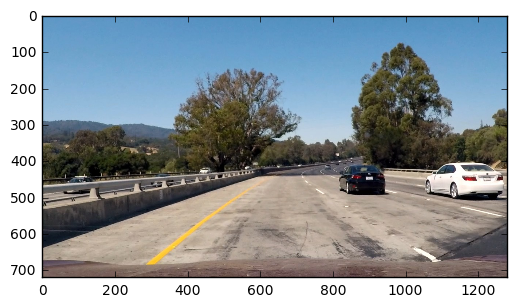

In [3]:
#For the pipeline-build, we'll use this image

plt.imshow(test_images[1])
plt.show()

    Part 3: Define Control Parameters

In [8]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell=8
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
ystart = 400
ystop = 650
scale = 1

    Part 4: Define basic functions

In [9]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

    Part 5: Feature extraction

In [10]:
def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

    Part 6: Training the data

In [11]:
cars = glob.iglob('train/vehicles/**/*.png')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcars = glob.iglob('train/non-vehicles/**/*.png')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Feature extraction complete")

Feature extraction complete


In [12]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
print("Data Scaled")

Data Scaled


In [13]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()

svc.fit(X_train, y_train)

print("Trained with SVC")
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Trained with SVC
Test Accuracy of SVC =  0.993


    Part 7: Finding cars

    Part 7.1: Detection Area

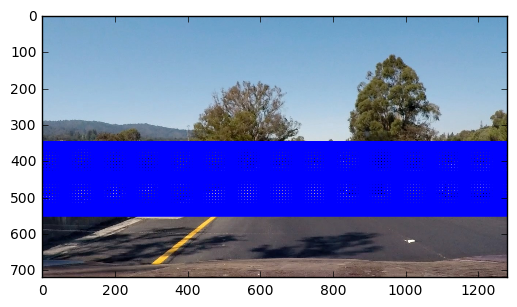

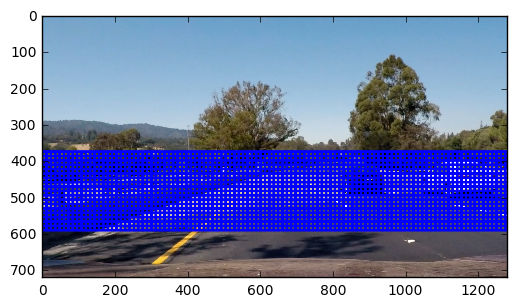

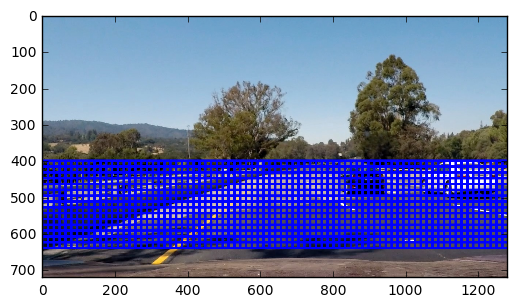

In [14]:
#Detection area
testarea=np.copy(test_images[3])
ystart=350
overlap=0.875
wsize=64
stepsize = int(wsize*(1-overlap))
sidecount = int(testarea.shape[1]//stepsize-1)

for i in range(18):
    for j in range(sidecount):
        abox=(j*stepsize,ystart+i*stepsize),(j*stepsize+wsize,ystart+i*stepsize+wsize)
        cv2.rectangle(testarea, abox[0], abox[1], (0,0,255), 6)
plt.imshow(testarea)
plt.show()

testarea=np.copy(test_images[3])
ystart=375
overlap=0.875
wsize=96
stepsize = int(wsize*(1-overlap))
sidecount = int(testarea.shape[1]//stepsize-1)

for i in range(11):
    for j in range(sidecount):
        abox=(j*stepsize,ystart+i*stepsize),(j*stepsize+wsize,ystart+i*stepsize+wsize)
        cv2.rectangle(testarea, abox[0], abox[1], (0,0,255), 6)
plt.imshow(testarea)
plt.show()

testarea=np.copy(test_images[3])
ystart=400
overlap=0.875
wsize=128
stepsize = int(wsize*(1-overlap))
sidecount = int(testarea.shape[1]//stepsize-1)

for i in range(8):
    for j in range(sidecount):
        abox=(j*stepsize,ystart+i*stepsize),(j*stepsize+wsize,ystart+i*stepsize+wsize)
        cv2.rectangle(testarea, abox[0], abox[1], (0,0,255), 6)
plt.imshow(testarea)
plt.show()

    Part 7.2: Calculating image parameters

In [15]:
image = test_images[3].copy()
box_list=[]
draw_img = np.copy(image)
image = image.astype(np.float32)/255

pix_per_cell = 8 # HOG pixels per cell
ystart = 350
ystop = 550


img_tosearch = image[ystart:ystop,:,:]
ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
if scale != 1:
    imshape = ctrans_tosearch.shape
    ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
ch1 = ctrans_tosearch[:,:,0]
ch2 = ctrans_tosearch[:,:,1]
ch3 = ctrans_tosearch[:,:,2]

# Define blocks and steps as above
cellinwide = (ch1.shape[1] // pix_per_cell)-1
print("Cells in Width:",cellinwide)
cellinlong = (ch1.shape[0] // pix_per_cell)-1 
print("Cells in Height:",cellinlong)
nfeat_per_block = orient*cell_per_block**2
print("HOG Features:",nfeat_per_block)
window = 64
print("Selected window Size:",window)
nblocks_per_window = (window // pix_per_cell)-1 
print("Cells in each window:",nblocks_per_window)
cells_per_step = 1
print("Cells stepped in each iteration:",nblocks_per_window)
nxsteps = (cellinwide - nblocks_per_window) // cells_per_step
nysteps = (cellinlong - nblocks_per_window) // cells_per_step
print("Steps in Width:",nxsteps)
print("Steps in Height:",nysteps)

Cells in Width: 159
Cells in Height: 24
HOG Features: 36
Selected window Size: 64
Cells in each window: 7
Cells stepped in each iteration: 7
Steps in Width: 152
Steps in Height: 17


    Part 7.3: Getting the HOG features

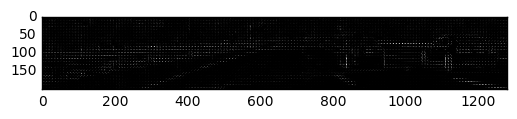

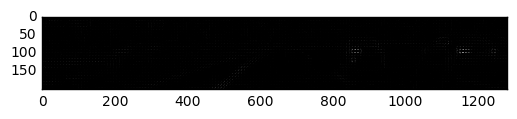

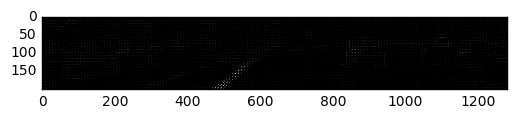

In [16]:
# Compute individual channel HOG features for the entire image
hog1, h1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
hog2, h2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
hog3, h3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

plt.imshow(h1, cmap='gray')
plt.show()
plt.imshow(h2, cmap='gray')
plt.show()
plt.imshow(h3, cmap='gray')
plt.show()

    Part 7.4: Finding HOG, spatial and color features with prediction

In [595]:
for xb in range(nxsteps):
    for yb in range(nysteps):
        ypos = yb*cells_per_step
        xpos = xb*cells_per_step
        # Extract HOG for this patch
        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        
        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        # Extract the image patch
        subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
        #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
        test_prediction = svc.predict(test_features)
            
        if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            boxy = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
            box_list.append(boxy)
print("List of points where car may be:",box_list)

List of points where car may be: [((816, 414), (880, 478)), ((824, 406), (888, 470)), ((824, 414), (888, 478)), ((824, 422), (888, 486)), ((832, 390), (896, 454)), ((832, 398), (896, 462)), ((832, 414), (896, 478)), ((832, 422), (896, 486)), ((832, 430), (896, 494)), ((840, 414), (904, 478)), ((840, 422), (904, 486)), ((848, 406), (912, 470)), ((848, 414), (912, 478)), ((856, 398), (920, 462)), ((856, 406), (920, 470)), ((856, 414), (920, 478)), ((856, 422), (920, 486)), ((864, 398), (928, 462)), ((864, 406), (928, 470)), ((864, 414), (928, 478)), ((864, 422), (928, 486)), ((872, 398), (936, 462)), ((872, 406), (936, 470)), ((872, 422), (936, 486)), ((872, 430), (936, 494)), ((872, 438), (936, 502)), ((880, 398), (944, 462)), ((880, 414), (944, 478)), ((880, 422), (944, 486)), ((880, 430), (944, 494)), ((880, 438), (944, 502)), ((880, 446), (944, 510)), ((1160, 438), (1224, 502)), ((1160, 446), (1224, 510)), ((1168, 430), (1232, 494)), ((1168, 446), (1232, 510)), ((1184, 430), (1248, 4

    Part 7.5: Forming the Heat map

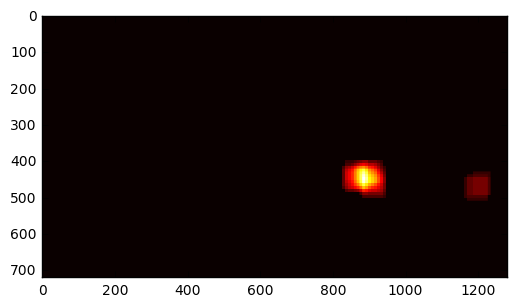

In [596]:
heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)

heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

plt.imshow(heatmap, cmap='hot')
plt.show()

    Part 7.6: Finding the cars

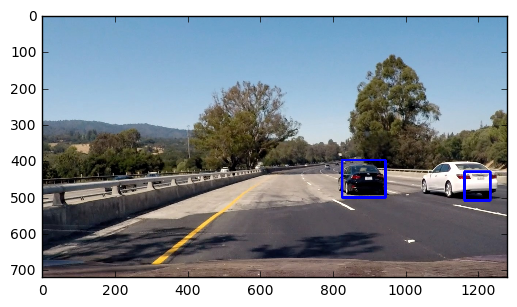

In [571]:
labels = label(heatmap)
boximg = np.copy(draw_img)
for car_number in range(1, labels[1]+1):
    # Find pixels with each car_number label value
    nonzero = (labels[0] == car_number).nonzero()
    # Identify x and y values of those pixels
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Define a bounding box based on min/max x and y
    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    # Draw the box on the image
    cv2.rectangle(boximg, bbox[0], bbox[1], (0,0,255), 6)

plt.imshow(boximg, cmap='hot')
plt.show()

    Part 8: The pipeline

In [572]:
def find_cars(image, video=1):
    
    
    box_list=[]
    draw_img = np.copy(image)
    image = image.astype(np.float32)/255
    

    
    ##########################################
    # Search 1: 8 pix per cell, 64x64 pixels #
    ##########################################
    
    pix_per_cell = 8 # HOG pixels per cell
    ystart = 350
    ystop = 550
    
    img_tosearch = image[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)    

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxy = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                box_list.append(boxy)
    
    
    #############################################
    # Search 2: 12 pix per cell, 96x96 pixels #
    #############################################
    
    pix_per_cell = 12 # HOG pixels per cell
    ystart = 375
    ystop = 600
    
    img_tosearch = image[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 96
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)  

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (96,96))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxy = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                box_list.append(boxy)
    
    
    #############################################
    # Search 3: 16 pix per cell, 128x128 pixels #
    #############################################
    
    pix_per_cell = 16 # HOG pixels per cell
    ystart = 400
    ystop = 650
    
    img_tosearch = image[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 128
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)  

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (128,128))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxy = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                box_list.append(boxy)
    
    
            
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    if (video == 1):
        heat = add_heat(heat,heater)
        heat = add_heat(heat,heatest)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
    else:
        heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    boximg = np.copy(draw_img)
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(boximg, bbox[0], bbox[1], (0,0,255), 6)
    
    global heater
    global heatest
    heatest = heater
    heater = box_list
                
    return boximg

    Part 8.1: Image Pipeline

In [1]:
heater = []
heatest = []
out = find_cars(test_images[3], video=0)
fig = plt.figure()
plt.imshow(out)
plt.title('Car Positions')
plt.show()

NameError: name 'find_cars' is not defined

    Part 8.2: Video pipeline

In [574]:
heater = []
heatest = []
car_finder = 'car.mp4'
clip1 = VideoFileClip("project_video.mp4")
car_clip = clip1.fl_image(find_cars)
%time car_clip.write_videofile(car_finder, audio=False)

[MoviePy] >>>> Building video testcar.mp4
[MoviePy] Writing video testcar.mp4


 97%|█████████▋| 38/39 [02:46<00:04,  4.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testcar.mp4 

CPU times: user 6min 7s, sys: 5.46 s, total: 6min 12s
Wall time: 2min 48s


End of Project